In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import math


# 1. Data Preprocessing
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class ComplexTransformerAutoencoder(nn.Module):
    def __init__(self, 
                 input_dim=21,
                 d_model=256,
                 nhead=8,
                 num_encoder_layers=6,
                 dim_feedforward=512,
                 dropout=0.2,
                 activation="gelu"):
        super(ComplexTransformerAutoencoder, self).__init__()
        
        # Input Processing
        self.input_embedding = nn.Sequential(
            nn.Linear(input_dim, d_model//2),
            nn.LayerNorm(d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_encoder_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        # Decoder Head
        self.decoder_head = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.LayerNorm(dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, input_dim),
            nn.Sigmoid()
        )
        
        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.LayerNorm(dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Input embedding
        x = self.input_embedding(x)
        
        # Add sequence dimension if needed
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        # Encoder
        encoded = self.transformer_encoder(x)
        
        # Decoder head (ensure correct dimensions)
        reconstruction = self.decoder_head(encoded.squeeze(1))  # Remove sequence dimension
        
        # Classifier head
        classification = self.classifier(encoded.mean(dim=1))  # Mean pooling across sequence
        
        # Ensure reconstruction has same dimensions as input
        reconstruction = reconstruction.view(batch_size, -1)  # Reshape to match input
        
        return reconstruction, classification

def train_complex_model(model, train_loader, val_loader, num_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # Scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2
    )
    
    # Loss functions
    recon_criterion = nn.MSELoss()
    class_criterion = nn.BCELoss()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass
            reconstruction, classification = model(features)
            
            # Ensure dimensions match
            features = features.view(features.size(0), -1)  # Flatten input
            reconstruction = reconstruction.view(reconstruction.size(0), -1)  # Flatten output
            
            # Calculate losses
            recon_loss = recon_criterion(reconstruction, features)
            class_loss = class_criterion(classification.squeeze(), labels)
            
            # Total loss
            loss = 0.5 * recon_loss + 0.5 * class_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            total_loss += loss.item()
        
        # Update scheduler
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                
                # Forward pass
                reconstruction, classification = model(features)
                
                # Ensure dimensions match
                features = features.view(features.size(0), -1)
                reconstruction = reconstruction.view(reconstruction.size(0), -1)
                
                val_preds.extend(classification.squeeze().cpu().numpy())
                val_true.extend(labels.cpu().numpy())
                
                # Calculate validation losses
                recon_loss = recon_criterion(reconstruction, features)
                class_loss = class_criterion(classification.squeeze(), labels)
                val_loss += (0.5 * recon_loss + 0.5 * class_loss).item()
        
        # Calculate metrics
        roc_auc = roc_auc_score(val_true, val_preds)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        print(f'ROC-AUC Score: {roc_auc:.4f}\n')
# Load and preprocess data
data = pd.read_csv('/kaggle/input/higgs-dataset/HIGGS.csv/HIGGS.csv')
features = data.iloc[:1100000, 1:22].values  # First 21 features
labels = data.iloc[:1100000, 0].values
    
# Split into train and test
train_features = features[:900000]              # First 900k for training
train_labels = labels[:900000]
    
val_features = features[900000:1000000]         # Next 100k for validation
val_labels = labels[900000:1000000]
    
test_features = features[1000000:]              # Last 100k for testing
test_labels = labels[1000000:]
    
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)    # Use same scaler parameters
test_features = scaler.transform(test_features)  # Use same scaler parameters
    
    # Create datasets
train_dataset = CustomDataset(train_features, train_labels)
val_dataset = CustomDataset(val_features, val_labels)
test_dataset = CustomDataset(test_features, test_labels)
    
    # Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
# Initialize model
model = ComplexTransformerAutoencoder()
# model_path = "/kaggle/input/higgs-autoencoder-epoch-10/pytorch/default/1/higgs_autoencoder.pth"
# model.load_state_dict(torch.load(model_path))
# Training parameters
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 30
    
# Train the model
#train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
train_complex_model(model, train_loader, val_loader)
torch.save(model.state_dict(), "higgs_complex_autoencoder.pth")
    

Epoch [1/50]
Training Loss: 0.6105
Validation Loss: 0.5801
ROC-AUC Score: 0.7090

Epoch [2/50]
Training Loss: 0.5848
Validation Loss: 0.5711
ROC-AUC Score: 0.7303

Epoch [3/50]
Training Loss: 0.5801
Validation Loss: 0.5676
ROC-AUC Score: 0.7372

Epoch [4/50]
Training Loss: 0.5769
Validation Loss: 0.5655
ROC-AUC Score: 0.7427

Epoch [5/50]
Training Loss: 0.5742
Validation Loss: 0.5627
ROC-AUC Score: 0.7487

Epoch [6/50]
Training Loss: 0.5713
Validation Loss: 0.5599
ROC-AUC Score: 0.7534

Epoch [7/50]
Training Loss: 0.5682
Validation Loss: 0.5570
ROC-AUC Score: 0.7592

Epoch [8/50]
Training Loss: 0.5657
Validation Loss: 0.5544
ROC-AUC Score: 0.7642

Epoch [9/50]
Training Loss: 0.5637
Validation Loss: 0.5517
ROC-AUC Score: 0.7695

Epoch [10/50]
Training Loss: 0.5623
Validation Loss: 0.5511
ROC-AUC Score: 0.7707

Epoch [11/50]
Training Loss: 0.5771
Validation Loss: 0.5652
ROC-AUC Score: 0.7440

Epoch [12/50]
Training Loss: 0.5767
Validation Loss: 0.5652
ROC-AUC Score: 0.7451

Epoch [13/50]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

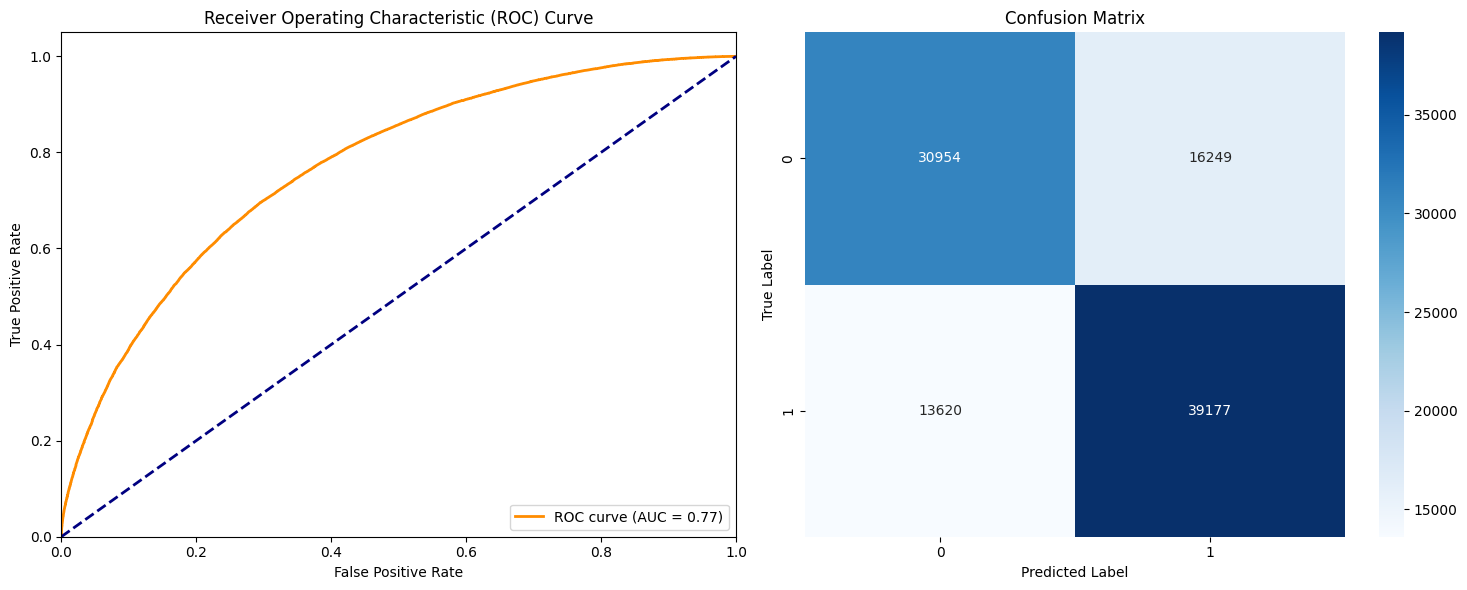

AUC Score: 0.7707
Optimal Threshold: 0.5336
Precision: 0.7068
Recall: 0.7420
F1 Score: 0.7240
Accuracy: 0.7013


In [4]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Final evaluation on test set
model.eval()
test_preds = []
test_true = []
    
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        _, classification = model(features)
        test_preds.extend(classification.squeeze().cpu().numpy())
        test_true.extend(labels.numpy())

y_true = np.array(test_true)
y_scores = np.array(test_preds)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2,label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")
    
y_pred = (y_scores >= 0.5).astype(int)
    
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title('Confusion Matrix')
    
plt.tight_layout()
plt.show()
    
# Calculate additional metrics
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
    
# Compute precision, recall, F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
    
print(f"AUC Score: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {np.mean(y_pred == y_true):.4f}")



